#Recriando os dados e realizando o pré-processamento da base

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# --- Geração e Salvar o Arquivo (Recriando df_churn_sintetico.csv) ---
np.random.seed(42)
n = 500
idade = np.random.randint(18, 70, n)
tempo_uso = np.random.exponential(scale=24, size=n).clip(1, 120).round(1)
interacoes = np.random.poisson(lam=tempo_uso / 5).clip(0, None)
satisfacao = np.random.randint(1, 5 + 1, n)
reclamacoes = np.random.poisson(lam=(6 - satisfacao) / 2).clip(0, None)
gasto_mensal = np.random.normal(300, 120, n).clip(20, 1500).round(2)
genero = np.random.choice(['Feminino', 'Masculino', 'Não-binário', 'Prefiro não informar'], n, p=[0.48, 0.48, 0.02, 0.02])
raca = np.random.choice(['Branca', 'Preta', 'Parda', 'Amarela', 'Indígena', 'Prefiro não informar'], n, p=[0.42, 0.10, 0.45, 0.01, 0.01, 0.01])
area_formacao = np.random.choice(['Humanas', 'Exatas', 'Biológicas', 'Negócios', 'Tecnologia', 'Artes'], n)

df = pd.DataFrame({'idade': idade, 'tempo_uso': tempo_uso, 'interacoes': interacoes, 'satisfacao': satisfacao, 'reclamacoes': reclamacoes, 'gasto_mensal': gasto_mensal, 'genero': genero, 'raca': raca, 'area_formacao': area_formacao})

score_churn = ((5 - df['satisfacao']) * 0.4 + (df['reclamacoes']) * 0.3 + (1 / (df['interacoes'] + 1)) * 0.2 + (1 / (df['tempo_uso'] + 1)) * 0.1)
score_churn = (score_churn - score_churn.min()) / (score_churn.max() - score_churn.min())
df['churn'] = np.random.binomial(1, score_churn)

df.to_csv('df_churn_sintetico.csv', index=False)
print("✅ Arquivo 'df_churn_sintetico.csv' gerado.")

# --- PRÉ-PROCESSAMENTO (Executado uma vez) ---
df_encoded = pd.get_dummies(df, columns=['genero', 'raca', 'area_formacao'], drop_first=True)
X = df_encoded.drop('churn', axis=1)
y = df_encoded['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("✅ Dados prontos para treino e teste.")

✅ Arquivo 'df_churn_sintetico.csv' gerado.
✅ Dados prontos para treino e teste.


# Fazendo gráfico da taxa média de Churn por área de formação e da relação entre tempo de uso e gasto mensal

--- 1. Gráficos Adicionais de Data Understanding ---
✅ Gráfico 'churn_por_area_formacao.png' exibido e salvo.
✅ Gráfico 'tempo_uso_vs_gasto_mensal.png' exibido e salvo.


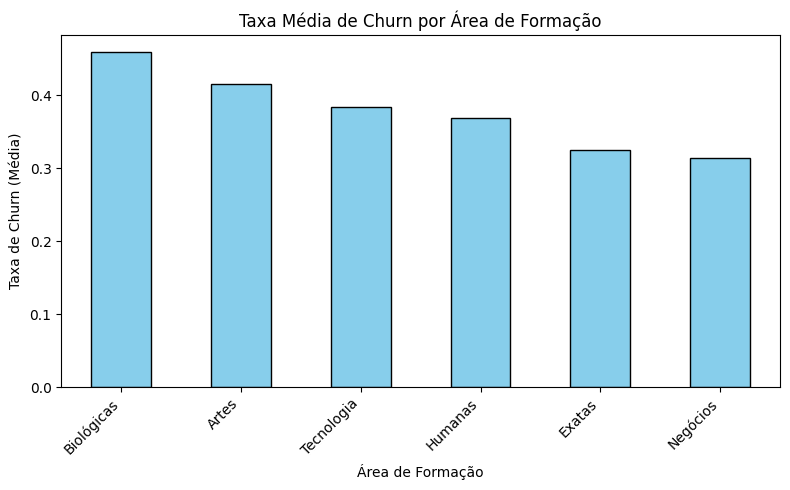

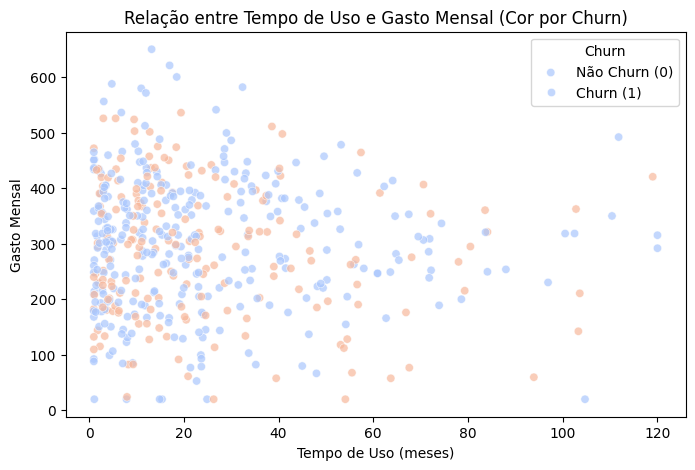

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Carrega os dados
df = pd.read_csv('df_churn_sintetico.csv')

print("--- 1. Gráficos Adicionais de Data Understanding ---")

# Gráfico 1.1: Taxa de Churn por Área de Formação
churn_por_area = df.groupby('area_formacao')['churn'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
churn_por_area.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Taxa Média de Churn por Área de Formação')
plt.ylabel('Taxa de Churn (Média)')
plt.xlabel('Área de Formação')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('churn_por_area_formacao.png')
# O gráfico será exibido aqui
print("✅ Gráfico 'churn_por_area_formacao.png' exibido e salvo.")


# Gráfico 1.2: Relação entre Tempo de Uso e Gasto Mensal (com cor de Churn)
plt.figure(figsize=(8, 5))
sns.scatterplot(x='tempo_uso', y='gasto_mensal', hue='churn', data=df, palette='coolwarm', alpha=0.7)
plt.title('Relação entre Tempo de Uso e Gasto Mensal (Cor por Churn)')
plt.xlabel('Tempo de Uso (meses)')
plt.ylabel('Gasto Mensal')
plt.legend(title='Churn', labels=['Não Churn (0)', 'Churn (1)'])
plt.savefig('tempo_uso_vs_gasto_mensal.png')
# O gráfico será exibido aqui
print("✅ Gráfico 'tempo_uso_vs_gasto_mensal.png' exibido e salvo.")

# Testando random forest

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

print("--- 2. Testando Outros Modelos (Random Forest Base) ---")

# Criando e treinando o modelo Random Forest
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train, y_train)

# Avaliação
y_pred_rf = rf_base.predict(X_test)
print("\nRelatório de Classificação (Random Forest Base):")
print(classification_report(y_test, y_pred_rf))

# Salva o modelo base para comparação
import joblib
joblib.dump(rf_base, 'rf_base_model.pkl')
print("✅ Modelo 'rf_base_model.pkl' salvo.")

--- 2. Testando Outros Modelos (Random Forest Base) ---

Relatório de Classificação (Random Forest Base):
              precision    recall  f1-score   support

           0       0.75      0.85      0.80        62
           1       0.69      0.53      0.60        38

    accuracy                           0.73       100
   macro avg       0.72      0.69      0.70       100
weighted avg       0.72      0.73      0.72       100

✅ Modelo 'rf_base_model.pkl' salvo.


# GridSearch para encontrar os melhores hiperparâmetros do random forest

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib

print("--- 3. Grid Search para Otimização de Hiperparâmetros ---")

# Definindo a grade de hiperparâmetros para o Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],      # Número de árvores
    'max_depth': [5, 10, None],          # Profundidade máxima da árvore
    'min_samples_split': [2, 5]          # Mínimo de amostras para dividir um nó
}

# Configurando o GridSearchCV (Otimiza para F1-score)
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=5, # 5-fold cross-validation
    n_jobs=-1
)

# Executando a busca em grade
grid_search.fit(X_train, y_train)

# Obtendo o melhor modelo
best_rf_model = grid_search.best_estimator_

print(f"\nMelhores Hiperparâmetros: {grid_search.best_params_}")

# Avaliação do Melhor Modelo (Otimizado)
y_pred_best = best_rf_model.predict(X_test)
print("\nRelatório de Classificação (Random Forest Otimizado):")
print(classification_report(y_test, y_pred_best))

# Salva o modelo otimizado
joblib.dump(best_rf_model, 'best_rf_model.pkl')
print("✅ Modelo Otimizado 'best_rf_model.pkl' salvo.")

--- 3. Grid Search para Otimização de Hiperparâmetros ---

Melhores Hiperparâmetros: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}

Relatório de Classificação (Random Forest Otimizado):
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        62
           1       0.65      0.53      0.58        38

    accuracy                           0.71       100
   macro avg       0.69      0.67      0.68       100
weighted avg       0.70      0.71      0.70       100

✅ Modelo Otimizado 'best_rf_model.pkl' salvo.


# Alterando threshold para ver qual é o melhor

--- 4. Análise e Otimização do Threshold de Classificação ---
AUC (Area Under the Curve): 0.7699
Optimal Threshold (Youden's J): 0.3649
Novo F1-Score com Optimal Threshold: 0.6824

Relatório de Classificação (Threshold Otimizado):
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        62
           1       0.62      0.76      0.68        38

    accuracy                           0.73       100
   macro avg       0.72      0.74      0.72       100
weighted avg       0.75      0.73      0.73       100

✅ Gráfico 'curva_roc_threshold.png' exibido e salvo.


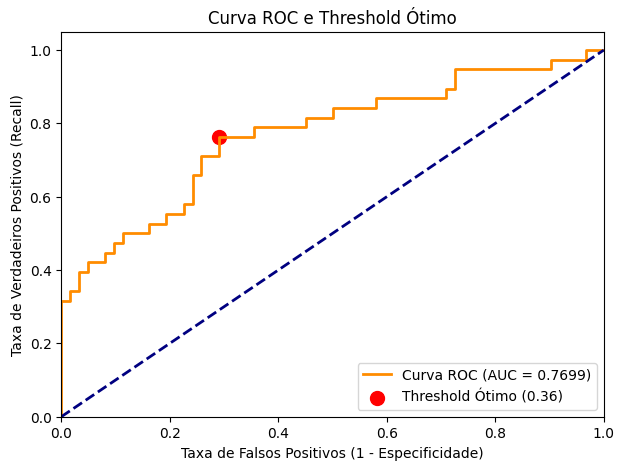

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, classification_report
import joblib

print("--- 4. Análise e Otimização do Threshold de Classificação ---")

# Carrega o melhor modelo (salvo na célula anterior)
try:
    best_rf_model = joblib.load('best_rf_model.pkl')
except FileNotFoundError:
    print("ERRO: O modelo 'best_rf_model.pkl' não foi encontrado. Execute a Célula 3.")
    # Usar um placeholder para evitar travar o resto do código
    y_scores = np.zeros(len(y_test))
    exit() # Interrompe a execução após o erro

# Previsão das probabilidades
y_scores = best_rf_model.predict_proba(X_test)[:, 1]

# 4.1. Encontrando o Threshold Ideal (Método Youden's J)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]
roc_auc = auc(fpr, tpr)

# 4.2. Análise e relatório
y_pred_new_th = (y_scores >= optimal_threshold).astype(int)
f1_new_th = f1_score(y_test, y_pred_new_th)

print(f"AUC (Area Under the Curve): {roc_auc:.4f}")
print(f"Optimal Threshold (Youden's J): {optimal_threshold:.4f}")
print(f"Novo F1-Score com Optimal Threshold: {f1_new_th:.4f}")
print("\nRelatório de Classificação (Threshold Otimizado):")
print(classification_report(y_test, y_pred_new_th))

# 4.3. Plotando a Curva ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', s=100, label=f'Threshold Ótimo ({optimal_threshold:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)')
plt.title('Curva ROC e Threshold Ótimo')
plt.legend(loc="lower right")
plt.savefig('curva_roc_threshold.png')
# O gráfico será exibido aqui
print("✅ Gráfico 'curva_roc_threshold.png' exibido e salvo.")